In [1]:
import numpy as np
import matplotlib.pylab as plt 
import scipy as sc
import scipy.optimize as op
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
import matplotlib.colors as colors
%matplotlib tk

## Lanzamiento de un tiro bidimensional en un contorno cerrado con dispersores en el centro
Por: Miguel Sabogal

### Model mesa de billar
Cómo modelo de estudio se considera el lanzamiento en dos dimensiones de una particula hacia el centro de un entorno circular cerrado (mesa de billar), con cuatro dispersores iguales (potenciales repulsivos) situados alrededor del centro de la mesa, donde el potencial de cada dispersor ésta dado por la expresión:
$$V_{i}(x,y)=A e^{-\alpha[ (x-x_{o_{i}})^{2} + (y-y_{o_{i}})^{2} ]}$$  

Donde la aceleración total que experimenta una particula durante su trayectoria, ésta dada por la expresión:
$$\dfrac{d^{2}\vec{r_{i}}}{dt^{2}}=\dfrac{2 \alpha A}{m} e^{-\alpha[ (x-x_{o_{i}})^{2} + (y-y_{o_{i}})^{2} ]} [(x-x_{o_{i}}),(y-y_{o_{i}})]$$

\begin{equation}
\dfrac{d^{2}\vec{r}}{dt^{2}} = \sum_{i=1}^{i=4} \dfrac{d^{2}\vec{r_{i}}}{dt^{2}}
\label{aceleracion}
\end{equation}

In [2]:
Parametros={"m":1,"x_o":-1,"v_o":3,"A":3,"alpha":0.5,"Radio":10,"V1":(1,1),"V2":(-1,1),"V3":(-1,-1),
            "V4":(1,-1),"h":1e-2}

In [3]:
class Potencial:
    """Esta clase contiene las caracteristicas del potencial y la aceleracion que experimenta una 
       particula de masa m que interectua con él"""

    def __init__(self,x_o,y_o,Amplitud,alpha,m):
        self.xo=x_o ; self.yo=y_o ; self.A=Amplitud ; self.alpha=alpha ; self.m=m
        
    def V(self,x,y):
        deltax= x-self.xo  ; deltay= y-self.yo 
        return self.A*np.e**(-self.alpha*(deltax**2 + deltay**2))
        
    def a(self,x,y):  
        ""
        deltax= x-self.xo  ; deltay= y-self.yo 
        return(2*self.A*self.alpha/self.m)*np.e**(-self.alpha*(deltax**2 + deltay**2))*np.array([deltax,deltay])
    
class Particula:
    """Ésta clase contiene la información sobre la trayectoria de la particula, posiciones, velocidades
       parametros de lanzamiento, tiempos, los potenciales con los que interactua , posee metodos
       que determinan el angulo de salida, el angulo de impacto, las energias del sistema, y las graficas 
       de trayectoria, de las energias y la intensidad del campo en 2-D y 3D."""
    
    def __init__(self,Vector_dinamico,tiempo,parametros,v1,v2,v3,v4):
        self.posx=Vector_dinamico[:,0]; self.posy=Vector_dinamico[:,1] ; self.velx=Vector_dinamico[:,2]
        
        self.vely=Vector_dinamico[:,3]; self.time=tiempo ; self.prm =parametros ; self.v1=v1  ; self.v2=v2 
        
        self.v3=v3 ; self.v4=v4
        
    def angulo_de_salida(self):
        theta = np.arctan((self.vely[-1])/(self.velx[-1]))*(90/(np.pi/2))
        if self.velx[-1] >= 0 and self.vely[-1] >= 0: return theta -90
        if self.velx[-1] <  0 and self.vely[-1] >= 0: return theta +90 
        if self.velx[-1] <  0 and self.vely[-1] <  0: return theta +90 
        if self.velx[-1] >= 0 and self.vely[-1] <  0: return theta -90
        
    def angulo_de_impacto(self):
        theta = np.arctan((self.posy[-1])/(self.posx[-1]))*(90/(np.pi/2))
        if self.posx[-1] >= 0 and self.posy[-1] >= 0: return theta -90 #primer cuadrante
        if self.posx[-1] <  0 and self.posy[-1] >= 0: return theta +90 #segundo
        if self.posx[-1] <  0 and self.posy[-1] <  0: return theta +90 #tercero
        if self.posx[-1] >= 0 and self.posy[-1] <  0: return theta -90 #cuarto  
        
    def Grafica_XvsY(self,second=0,x2=0,y2=0):
        x=np.linspace(-self.prm["Radio"],self.prm["Radio"],1000) 
        plt.plot(self.posx,self.posy) ; plt.xlabel("Desplazamiento en $x$",fontsize=15) 
            
        plt.ylabel("Desplazamiento en $y$",fontsize=15) ; plt.title("Trayectoria de tiro",fontsize=15) 
        plt.tick_params(axis="both",labelsize=12) ; plt.grid(True)
        
        plt.plot(x,np.sqrt(self.prm["Radio"]**2 - x**2),"black")        
        plt.plot(self.prm["V1"][0],self.prm["V1"][1],"g.")
        if second == 1: 
            plt.plot(x2,y2,"red")
            plt.legend(("Particula 1","Contorno de la mesa","Dispersores","Particula 2"),loc=1) 
        if second == 0: 
            plt.legend(("Particula 1","Contorno de la mesa","Dispersores"),loc=1)    
        plt.plot(x,-np.sqrt(self.prm["Radio"]**2 - x**2),"black",self.prm["V2"][0],self.prm["V2"][1],"g.")
        plt.plot(self.prm["V3"][0],self.prm["V3"][1],"g.",self.prm["V4"][0],self.prm["V4"][1],"g.")
        plt.show()
        
    def Energia(self):
        self.K=(self.prm["m"]/2)*(self.velx**2 + self.vely**2) 
        
        self.V=(self.v1.V(self.posx,self.posy)+ self.v2.V(self.posx,self.posy)
           +self.v3.V(self.posx,self.posy)+self.v4.V(self.posx,self.posy)) 
        
        self.E=self.K+self.V ; self.Vo=(self.v1.V(0,0)+self.v2.V(0,0)+self.v3.V(0,0)+self.v4.V(0,0)) 
        self.Eo=self.E[0]
        
        plt.plot(self.time,self.K,"blue",self.time,self.V,"red",self.time,self.E,"--") 
        plt.xlabel("Tiempo",fontsize=15) ; plt.ylabel("Energia",fontsize=15) 
        plt.title("Energias vs tiempo",fontsize=15);plt.grid(True)
        plt.legend(("Cinetica","Pontencial","Energia Total")) ; plt.tick_params(axis="both",labelsize=12)
        plt.show()
        
    def V_Visula_3D(self,delta):
        fig = plt.figure() ; ax = fig.add_subplot(1, 1, 1, projection='3d')
        X = np.arange(-5, 5, delta) ; Y = np.arange(-5, 5, delta) ; X, Y = np.meshgrid(X, Y)
        Z = self.v1.V(X,Y)+self.v2.V(X,Y)+self.v3.V(X,Y)+self.v4.V(X,Y)
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet,   #ax.plot_surface
        linewidth=0, antialiased=True)
        
        ax.set(xlabel="Desplazamiento en $x$", ylabel="Desplazamiento en $y$", zlabel="Intensidad del campo",
                title="Potenciales")
        
        plt.show()
        
    def V_Visual(self,delta):
        x = np.arange(-5, 5, delta) ; y = np.arange(-5, 5, delta) ; X, Y = np.meshgrid(x, y)
        Z = self.v1.V(X,Y)+self.v2.V(X,Y)+self.v3.V(X,Y)+self.v4.V(X,Y)

        fig, ax = plt.subplots()
        pcm= ax.pcolor(X, Y, Z,norm=cm.colors.Normalize(vmax=1, vmin=0))
        fig.colorbar(pcm, ax=ax, extend='max')
        cset1 = ax.contourf(X, Y, Z, 40)
        
        ax1 = fig.gca()
        ax1.plot(self.posx, self.posy,"r--")
        ax.set_xlim(-4.9, 4.9)
        ax.set_ylim(-4.9, 4.9)
    
        ax1.set(xlabel="Desplazamiento en $x$", ylabel="Desplazamiento en $y$",
                title="Trayectoria de tiro e intensidad del campo")
        
        plt.show()    

In [4]:
def Launch(prm,t_max=400):
    """Ésta función realiza un lanzamiento de la particula (evolucion de sistema), utilizando el runge kutta 
       de cuarto orden, teniendo en cuenta los parametros de entrada, y regresa una instancia de la clase 
       particula."""
    
    #condiciones iniciales
    y_launch=-3*prm["Radio"]/4 ; x_launch=prm["x_o"] ; Vo= prm["v_o"] ; theta=np.pi/2
    
    ro= np.array([x_launch,y_launch])  ; vo=Vo*np.array([np.cos(theta),np.sin(theta)]) 
    yo=np.hstack((ro,vo))
    
    #Se instancian los cuatro potenciales del estudio 
    Po_1=Potencial(prm["V1"][0],prm["V1"][1],prm["A"],prm["alpha"],prm["m"]) 
    Po_2=Potencial(prm["V2"][0],prm["V2"][1],prm["A"],prm["alpha"],prm["m"])
    Po_3=Potencial(prm["V3"][0],prm["V3"][1],prm["A"],prm["alpha"],prm["m"])
    Po_4=Potencial(prm["V4"][0],prm["V4"][1],prm["A"],prm["alpha"],prm["m"])
    
    #Función vectorial de derivadas (dx/dt, dv/dt)
    """Se define una funcion que representa la derivada del vector dinamico, la cual sera integrada por el 
       runge kutta"""
    def dydt(y,Po_1=Po_1,Po_2=Po_2,Po_3=Po_3,Po_4=Po_4): #y=(r,v) -- r=(x,y) -- v=(vx,vy) 
        a= Po_1.a(y[0],y[1]) + Po_2.a(y[0],y[1]) + Po_3.a(y[0],y[1]) + Po_4.a(y[0],y[1])
        return np.array([y[2],y[3],a[0],a[1]])

    def rk4_p(f,yo,R=prm["Radio"],h=prm["h"],t_max=t_max): #yo=(x_o,y_o,vx_o,vy_o)
        """Esta funcion realiza la evolucion del sistema utilizando el runge kutta de cuarto orden,
           regresa el vector dinamico (matriz de cuatro columnas) y el arreglo de tiempos"""
        
        #El sistema inicia en tiempo cero y desde las condiciones iniciales
        t=0      ;     x=np.array([yo]) ;      tiempo=[0]
        
        """Evoluciona desde t=0 hasta que la particula salga del circulo o se supere el tiempo maximo"""
        while (x[-1][0])**2 + (x[-1][1])**2 <= R**2 and t <= t_max or t==0:
            k1 = h*f(x[-1])               ;   k2 = h*f(x[-1]+0.5*k1)
            k3 = h*f(x[-1]+0.5*k2)        ;   k4 = h*f(x[-1]+k3)
            x = np.vstack(( x, x[-1]+(k1+2*(k2+k3)+k4)/6 )) 
            t+=h ; tiempo=np.hstack((tiempo,t))    
        """Se recacalcula la ultima posicion en un cuarto de paso del anterior"""    
        if (x[-1][0])**2 + (x[-1][1])**2 > R**2 and t <= t_max:
            h2=h/4
            k1 = h2*f(x[-2])               ;   k2 = h2*f(x[-2]+0.5*k1)
            k3 = h2*f(x[-2]+0.5*k2)        ;   k4 = h2*f(x[-2]+k3)
            x[-1] = x[-2]+(k1+2*(k2+k3)+k4)/6 
            tiempo[-1]=tiempo[-2]+h2 ; t=t-h+h2
            
        return x,tiempo
    #Se realiza la evolucion del sistema
    Launch=rk4_p(dydt,yo)
    """Regresa una instancia de la clase particula, con los datos calculados, y parametros."""
    return Particula(Launch[0],Launch[1],prm,Po_1,Po_2,Po_3,Po_4)    

In [9]:
Parametros={"m":1,"x_o":-0.7,"v_o":1.60005,"A":3,"alpha":0.5,"Radio":10,"V1":(2,2),"V2":(-2,2),
            "V3":(-2,-2),"V4":(2,-2),"h":1e-2} #"x_o":0.7,"v_o":1.2,"A":3,"alpha":0.3,"Radio":10 a=3 0.69
shot=Launch(Parametros,100) #0.65 1.60005

### Trayectoria

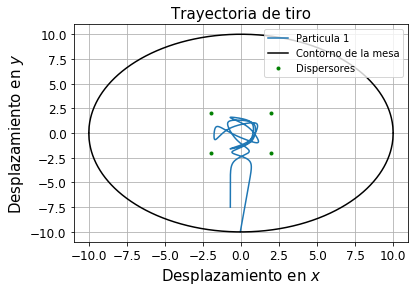

In [10]:
shot.Grafica_XvsY() 

### Energias del sistema

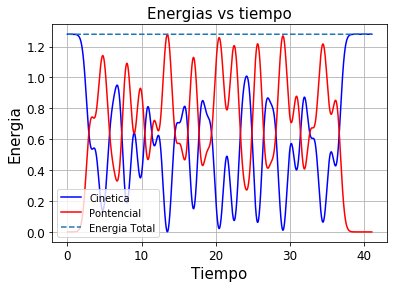

In [11]:
shot.Energia()

### Trayectoria e intensidad del campo (diaframa de colores) en 2-D

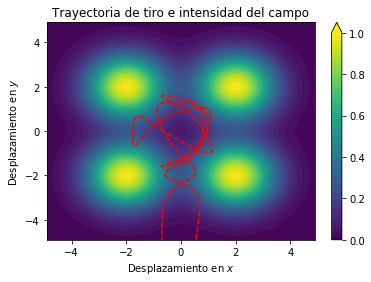

In [12]:
shot.V_Visual(1e-1)

### Intensidad del campo en 3-D

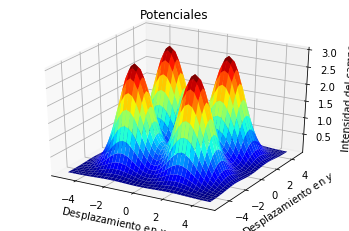

In [9]:
shot.V_Visula_3D(1e-1*2.5)

## Estudio del caos
A continuacion se muestra el estudio del caos en el sistema mediante los coeficientes de Lyapunov, para dos
trayectorias.

In [13]:
class Two_launches:
    """Ésta clase contiene la información sobre la dos trayectorias y su separacion, y los coeficientes 
       de Lyapunov; posee metodos que realizan las graficas de las trayectorias, del la separacion
       espacial en funcion del tiempo, los coeficientes en funcion de la dstancia media al centro, y 
       la separacion espacial en funcion de la distancia al centro para cada particula."""
    
    def __init__(self,prt_1,prt_2,deltas,Coeficientes,Amp,puntos_medios_1,puntos_medios_2,x,delta,prm,N):
        
        self.coeficientes=Coeficientes ; self.amplitudes=Amp ; self.puntos_medios_1= puntos_medios_1
        
        self.xo_1=x ; self.xo_2=x+delta ; self.prm=prm ; self.puntos_medios_2= puntos_medios_2
        
        self.particula_1=prt_1 ; self.particula_2=prt_2 ; self.deltas=deltas ;self.N_puntos_intervalo=N
        
    def Trayectorias(self):
        self.particula_1.Grafica_XvsY(second=1,x2=self.particula_2.posx,y2=self.particula_2.posy)
        plt.show()
        
    def Lyp_vs_r(self):
        plt.plot(self.puntos_medios_1,self.coeficientes,".",self.puntos_medios_2,self.coeficientes,".")
        plt.axhline(y=1,color="g",linestyle="--")
        if self.coeficientes.min() < -1: plt.axhline(y=-1,color="g",linestyle="--")
            
        plt.legend(("Particula 1","Particula 2","$ |\lambda|=1 $"))    
        plt.xlabel("Distancia media al centro de los potenciales",fontsize=15) 
        plt.ylabel("Coefiente de Lyapunov",fontsize=15) 
        plt.title("Distancia al centro vs Coefiente de Lyapunov",fontsize=15);plt.grid(True)
        plt.tick_params(axis="both",labelsize=12)
            
        plt.show()
        
    def delta_vs_r(self):
        plt.plot(np.sqrt(self.particula_1.posx**2 + self.particula_1.posy**2),self.deltas,"--") 
        plt.plot(np.sqrt(self.particula_2.posx**2 + self.particula_2.posy**2),self.deltas) 
        
        plt.legend(("Particula 1","Particula 2"))    
        plt.xlabel("Distancia al centro de los potenciales",fontsize=15) 
        plt.ylabel("Separacion entre trayectorias",fontsize=15) 
        plt.title("Distancia al centro vs separación",fontsize=15);plt.grid(True)
        plt.tick_params(axis="both",labelsize=12)
        
        plt.show()
        
    def delta_vs_time(self):
        plt.plot(self.particula_1.time,self.deltas,label="$\delta$ vs t")  
        
        plt.legend()    
        plt.xlabel("Tiempo",fontsize=15) 
        plt.ylabel("Separacion entre trayectorias",fontsize=15) 
        plt.title("Tiempo vs Separación",fontsize=15);plt.grid(True)
        plt.tick_params(axis="both",labelsize=12)
        
        plt.show()
        
    def best(self):
        """Encuentra la distancia del punto medio de las posicones analizadas, para el primer intervalo
           con un coeficiente mayor a 1, es decir donde empieza el caos."""
        this=0
        for i in range(len(self.coeficientes)):
            if abs(self.coeficientes[i])>=1:
                this=i
                break
        if this!=0:       
            self.max= self.puntos_medios_1[this]
            return self.max
        else: return "No hay Caos"
            

In [14]:
def Coeficientes_lyapunov(x,delta,prm,N):
    """Ésta funcion realiza 2 lanzamientos con una set de parametros constantes, determina el delta de sus
       posiciones, efectua un fitio para determinar los coeficientes de Lyapunov, enuevtra los puntos medios
       de los intervalos, y halla su distancia al centro de los potenciales. Regresa una instanca de la 
       clase Two_launches, con toda la informacion determinda. N es el tamaño de los intervalos a analizar"""
    
    #Condiciones iniciales de cada lanzamiento, y se realizan los dos lanzamientos.
    prm1=prm ; prm2=prm ; prm1["x_o"]=x ; proyec1=Launch(prm1) ; prm2["x_o"]=x + delta ; proyec2=Launch(prm2)
    
    """Determina cual tiene mayor longitud, y la corta con las mismas dimensiones de la otra trayectoria"""
    if len(proyec1.time) < len(proyec2.time):  prm2["x_o"]=x + delta; proyec2=Launch(prm2,proyec1.time[-1])
    if len(proyec1.time) > len(proyec2.time):  prm1["x_o"]=x ; proyec1=Launch(prm1,proyec2.time[-1])
        
    """Determina el delta del vector posicion para cada instante"""    
    deltar= np.sqrt( (proyec2.posx-proyec1.posx)**2 + (proyec2.posy-proyec1.posy)**2)
    
    def Delta(t,do,landa): return do*np.e**(landa*t) #funcion de fiteo para los coeficientes
    
    """Se encuentran el numero de intervalos a estudiar, y los arreglos a llenar"""
    N_intervalos= int(len(proyec1.time)/N)  ; lyapunov=[] ; D_o=[] ; r1_medio=[]; r2_medio=[]
    
    """Ejecuta el fiteo para cada intervalo"""
    for i in range(N_intervalos):
        fit=op.curve_fit(Delta,proyec1.time[i*N:(i+1)*N],deltar[i*N:(i+1)*N])
        
        d_o,landa=fit[0]
        lyapunov= np.hstack((lyapunov,landa))   
        D_o= np.hstack((D_o,d_o))   ; k= i*N #int (abs((i*N+(i+1)*N)/2))
        
        r1_medio=np.hstack((r1_medio, np.sqrt((proyec1.posx[k])**2+proyec1.posy[k]**2) ))
                           
        r2_medio=np.hstack((r2_medio, np.sqrt((proyec2.posx[k])**2+proyec2.posy[k]**2) ))
        
        if abs(d_o)< delta/100: # si el d_o enontrado es muy pequeño, en comparacion al delta inicial
            D_o=D_o[:-1]        # no genera informacion confiable, se borra su informacion
            lyapunov=lyapunov[:-1]
            r1_medio=r1_medio[:-1]
            r2_medio=r2_medio[:-1]
        
    """Regresa una instancia de la clase Two_launches, con los datos calculados, y parametros."""        
    return Two_launches(proyec1,proyec2,deltar,lyapunov,D_o,r1_medio,r2_medio,x,delta,prm,N)

In [15]:
Parametros={"m":1,"x_o":-0,"v_o":2.3,"A":3,"alpha":0.5,"Radio":10,"V1":(2,2),"V2":(-2,2),
            "V3":(-2,-2),"V4":(2,-2),"h":1e-2} 
two_shot=Coeficientes_lyapunov(-1.6,1e-1,Parametros,30)

### Trayectorias

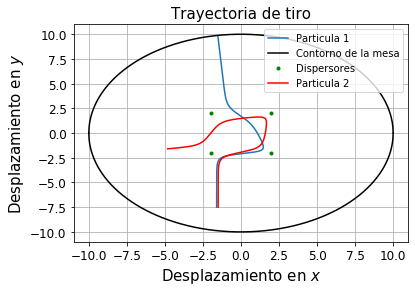

In [16]:
two_shot.Trayectorias()

### Separacion espacial en funcion del tiempo

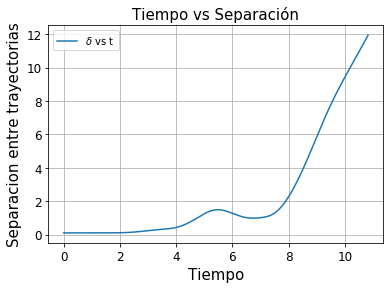

In [17]:
two_shot.delta_vs_time()

### Coeficientes de Lyapunov en funcion de la distancia al centro del punto medio del intervalo 

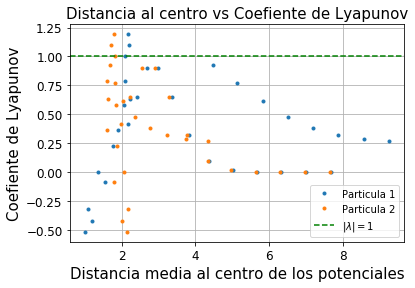

In [15]:
two_shot.Lyp_vs_r()

### Separacion espacial en funcion de la distancia al centro (instante a instante)

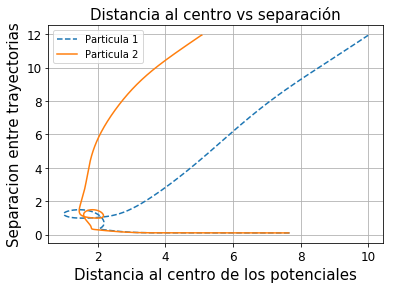

In [16]:
two_shot.delta_vs_r()

### Busqueda de la region caotica

In [17]:
class Caos:
    """Ésta clase contiene la información sobre el barrido del parametro de impacto, y los maximos 
       coeficientes para cada caso"""
    def __init__(self,landa,x,prm,N):
        self.Coeficientes=landa ; self.x=x ; self.prm=prm ; self.N=N
        
    def Grafica(self):    
        plt.plot(self.x,self.Coeficientes)
        plt.axhline(y=1,color="g",linestyle="--")   
        
        plt.ylabel("Maximo coeficiente de Lyapunov",fontsize=15) 
        plt.xlabel("Parametro de impacto",fontsize=15) 
        plt.title("Zonas caoticas",fontsize=15)
        plt.tick_params(axis="both",labelsize=12)
        
        plt.show()

def region_caotica(xi,xf,delta,prm,N):
    """Ésta funcion realiza un barrido desde xi hasta xf de los parametros de impacto, a paso de un delta,
       y almacena la maximo coeficiente encontrado para el par de trayectorias en cuestion"""
    x=np.arange(xi,xf,delta) ; landa=[]
    
    for i in range(len(x)):
        tiro=Coeficientes_lyapunov(x[i],delta,prm,N)
        Coeficientes=abs(tiro.coeficientes)
        landa=np.hstack((landa,Coeficientes.max() ))  
    """Regresa una instancia de la clase Caos, con los datos calculados, y parametros."""   
    return Caos(landa,x,prm,N)     

In [18]:
Parametros={"m":1,"x_o":-0.71,"v_o":2.3,"A":3,"alpha":0.5,"Radio":10,"V1":(2,2),"V2":(-2,2),
            "V3":(-2,-2),"V4":(2,-2),"h":1e-2} 
caos=region_caotica(-6,6,1e-1,Parametros,30)

/home/miguelsabogal/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


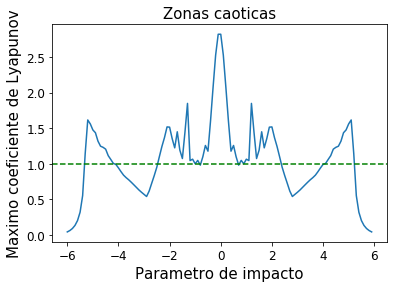

In [19]:
caos.Grafica()

## Estudio de la dispersión
A continuación se muestra el proceso para el analisis de la dispersion de las particulas 

In [20]:
class Many_launches:
    """Ésta clase contiene la información sobre varias trayectorias, y sus angulos de salida 
       e impacto; posee metodos que realizan las graficas de: la distribucion de impacto(para la seccion eficaz)
       y el angulo de salida en funcion del parametro de impacto."""
    
    def __init__(self,angulos_de_salida,angulos_de_impacto,prm_impacto,prm):
        self.angulos_de_salida =angulos_de_salida ; self.prm_impact= prm_impacto ; self.prm=prm
        self.angulos_de_impacto=angulos_de_impacto
        
    def Zone(self,intervalos):
        bins_y,bins_x=np.histogram(self.angulos_de_impacto,intervalos)
        p_medios_intervalos=np.array([ (bins_x[i-1]+bins_x[i])/2  for i in range(1,len(bins_x)) ])
        
        def Gaus(x,mean,sigma,b): return ((1/b)*np.e**(-(x-mean)**2 /(2*sigma**2)))  
        fit=op.curve_fit(Gaus,p_medios_intervalos,bins_y)
        mean,sigma,b=fit[0] ; self.mean=mean ; self.sigma=sigma
    
        plt.hist(self.angulos_de_impacto,intervalos)
        plt.plot(p_medios_intervalos,Gaus(p_medios_intervalos,mean,sigma,b)) 
        plt.xlabel("Angulo de salida",fontsize=15) ; plt.ylabel("Numero de impactos",fontsize=15) 
        plt.title("Distribución de impacto",fontsize=15); plt.tick_params(axis="both",labelsize=12)
        plt.show()
        
    def Angulo_salida_vs_prm_impacto(self):
        plt.plot(self.prm_impact,self.angulos_de_salida)
        
        plt.ylabel("Angulo de salida",fontsize=15) ; plt.xlabel("Parametro de impacto",fontsize=15) 
        plt.title("Parametro de impacto vs angulo de salida",fontsize=15)
        plt.tick_params(axis="both",labelsize=12)
        
        plt.show()
        
    def Angulo_impacto_vs_prm_impacto(self):
        plt.plot(self.prm_impact,self.angulos_de_impacto)
        
        plt.ylabel("Angulo de impacto",fontsize=15) ; plt.xlabel("Parametro de impacto",fontsize=15) 
        plt.title("Parametro de impacto vs angulo de impacto",fontsize=15)
        plt.tick_params(axis="both",labelsize=12)
        
        plt.show()   
        

In [21]:
def Varios_lanzamientos(prm,xi,xf,h):
    """Ésta funcion realiza lanzamientos desde un xi hasta un xf, con delta de h, y con una set de parametros 
       constantes, almacena los angulos de salida e imapcto de cada lanzamiento, y su parametro de impacto. 
       Reresa una instancia de la clase Many_launches, con toda la informacion determinada"""
    
    #arreglas a llenar con la informacion
    angulos_de_salida=[] ; prm_impact=[] ; angulos_de_impacto=[]
    #Realiza el barrido 
    while xi <= xf:
        prm["x_o"]=xi ; l=Launch(prm)
        angulos_de_salida=np.hstack((angulos_de_salida,l.angulo_de_salida()))
        angulos_de_impacto=np.hstack((angulos_de_impacto,l.angulo_de_impacto()))
        prm_impact=np.hstack((prm_impact,l.posx[0] ))
        xi+=h       
    """Regresa una instancia de la clase Many_launches, con los datos calculados, y parametros."""     
    return Many_launches(angulos_de_salida,angulos_de_impacto,prm_impact,prm) 

In [22]:
Parametros={"m":1,"x_o":-3,"v_o":2,"A":3,"alpha":0.5,"Radio":10,"V1":(2,2),"V2":(-2,2),
            "V3":(-2,-2),"V4":(2,-2),"h":1e-2}
launches=Varios_lanzamientos(Parametros,-5,5,1e-1)

### Angulo de salida en funcion del parametro de impacto.

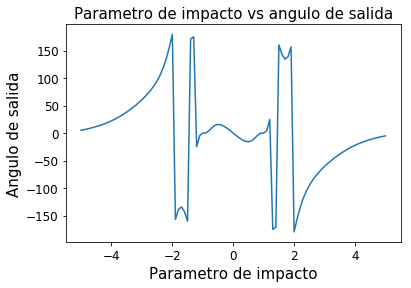

In [23]:
launches.Angulo_salida_vs_prm_impacto()

### Distribucion de impacto, para determinar la seccion eficaz.

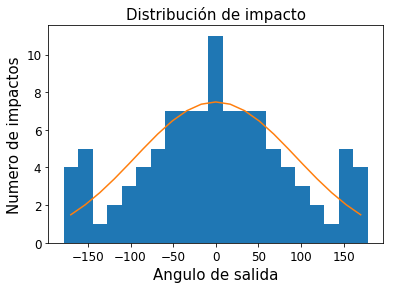

In [24]:
launches.Zone(21)